In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [228]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("------------------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
def evals_():
    print("y_train / y_train_pred ")
    eval_metrics(y_train, y_train_pred)

def rms_() :
    trainscore = int(math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Train Score: %.f RMSE" % (trainscore))

In [163]:
df = pd.read_csv('Bitcoin-2015-2022.csv')
df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)
df = df.drop(columns=['Price'])
df["High"] = df["High"].str.replace(',','')
df["High"] = df["High"].astype(float)
df["Low"] = df["Low"].str.replace(',','')
df["Low"] = df["Low"].astype(float)
df["Price"] = (df.High + df.Low)/2
df.index = df.Date
df.head()

,Date,Open,High,Low,Vol.,Change %,Price
Date,,,,,,,
2021-12-31,2021-12-31,"47,123.3",48553.9,45693.6,58.18K,-1.92%,47123.75
2021-12-30,2021-12-30,"46,470.7",47901.4,46003.0,60.96K,1.42%,46952.20
2021-12-29,2021-12-29,"47,548.4",48121.7,46127.8,63.92K,-2.28%,47124.75
2021-12-28,2021-12-28,"50,703.4",50703.8,47345.7,74.39K,-6.18%,49024.75
2021-12-27,2021-12-27,"50,783.6",52016.3,50459.0,43.90K,-0.20%,51237.65


In [164]:
df = df.drop(columns=['Date',"Open","High","Low","Vol.","Change %"])
df = df.iloc[::-1]

In [165]:
df.head()

,Price
Date,
2015-01-01,317.45
2015-01-02,314.75
2015-01-03,300.35
2015-01-04,272.90
2015-01-05,270.60


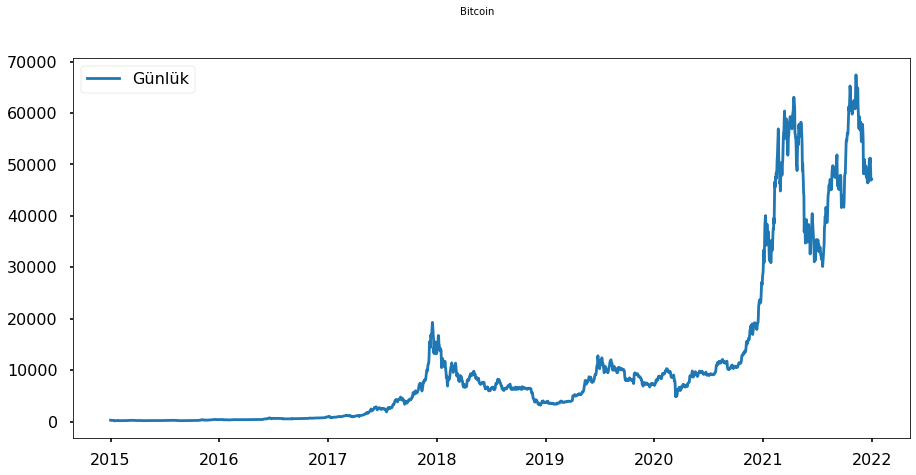

In [166]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin', fontsize=10)
plt.plot(df.Price, '-', label='Günlük')
plt.legend()

## Serinin durağanlık kontrolü

<Figure size 1080x504 with 0 Axes>

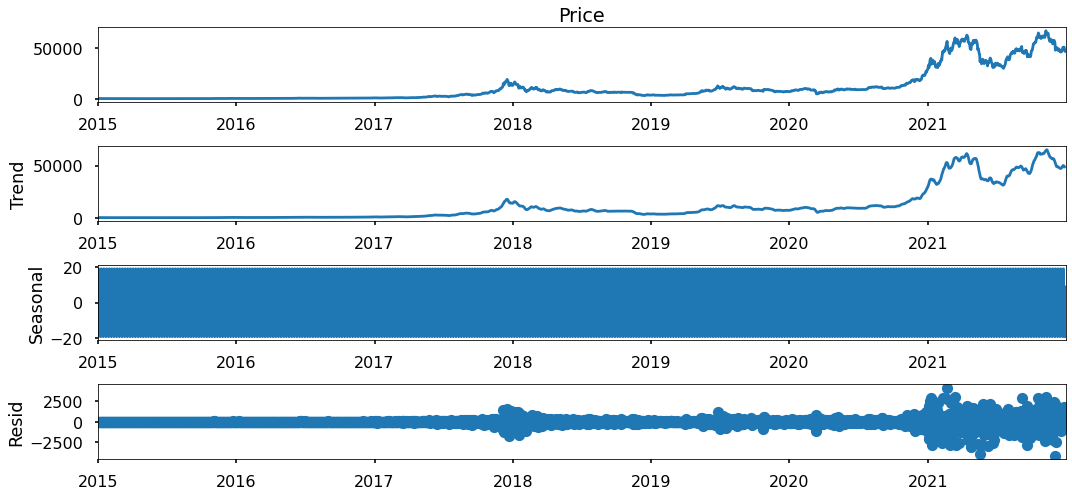

In [229]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df.Price).plot()
plt.show()

In [168]:
print("Dickey–Fuller test: p =" , sm.tsa.stattools.adfuller(df.Price)[1])

Dickey–Fuller test: p = 0.8703650816338417


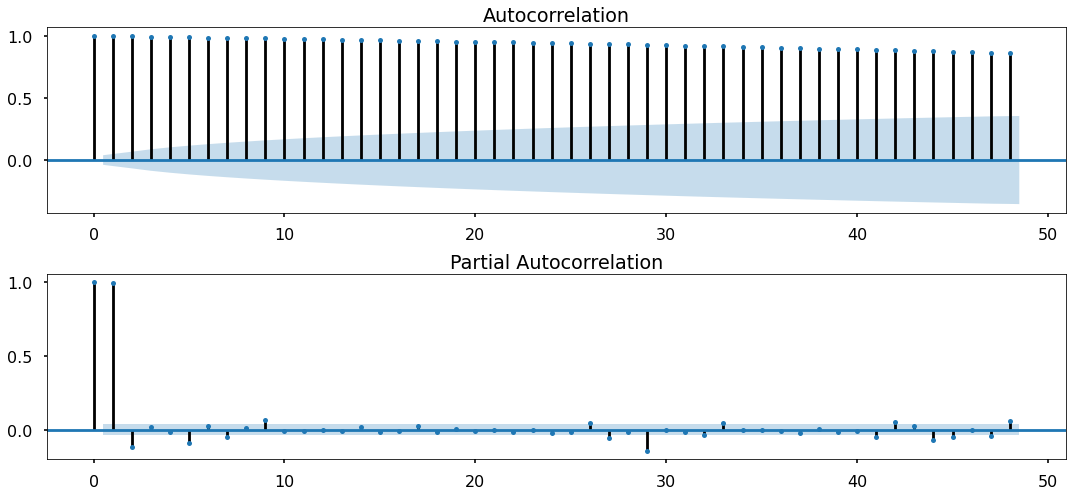

In [169]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Price.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Price.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()


**Seri durağan değil**

### Box-Cox Dönüşümleri

In [170]:
df['Price_box_cox'], lmbda = stats.boxcox(df.Price)
print("lambda: ",lmbda)
df.head()

lambda:  0.07228900999717235


,Price,Price_box_cox
Date,,
2015-01-01,317.45,7.144990
2015-01-02,314.75,7.132041
2015-01-03,300.35,7.061186
2015-01-04,272.90,6.916921
2015-01-05,270.60,6.904229


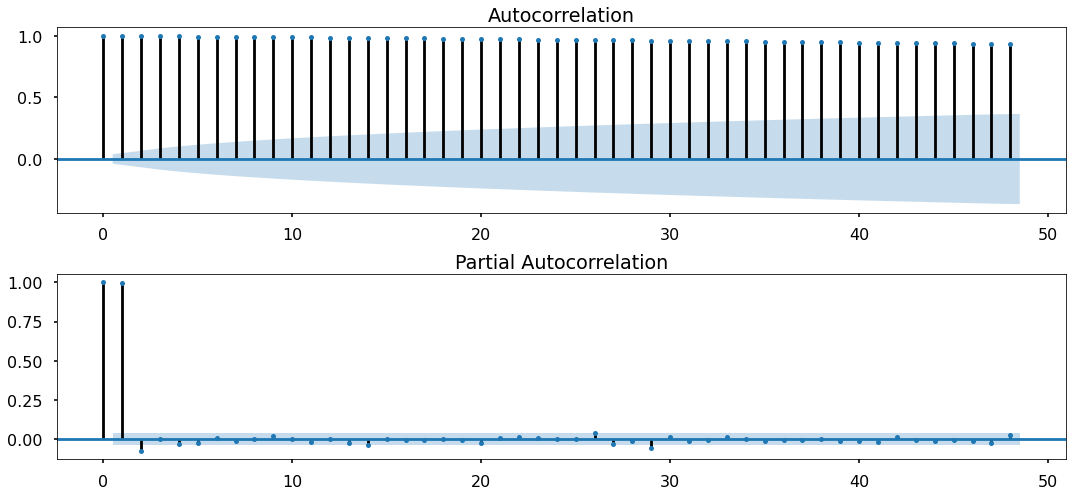

In [230]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Price_box_cox.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Price_box_cox.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [198]:
print("Dickey–Fuller test: p = " , sm.tsa.stattools.adfuller(df.Price_box_cox)[1])

Dickey–Fuller test: p =  0.8849618323188679


**Seri hala durağan değil**

## Mevsimsel Fark

In [173]:
df['Price_box_cox_s_diff'] = df.Price_box_cox -  df.Price_box_cox.shift(7)

In [174]:
df.head(10)

,Price,Price_box_cox,Price_box_cox_s_diff
Date,,,
2015-01-01,317.45,7.144990,NaN
2015-01-02,314.75,7.132041,NaN
2015-01-03,300.35,7.061186,NaN
2015-01-04,272.90,6.916921,NaN
2015-01-05,270.60,6.904229,NaN
2015-01-06,278.30,6.946333,NaN
2015-01-07,288.40,6.999952,NaN
2015-01-08,285.85,6.986581,-0.158409
2015-01-09,283.95,6.976546,-0.155494


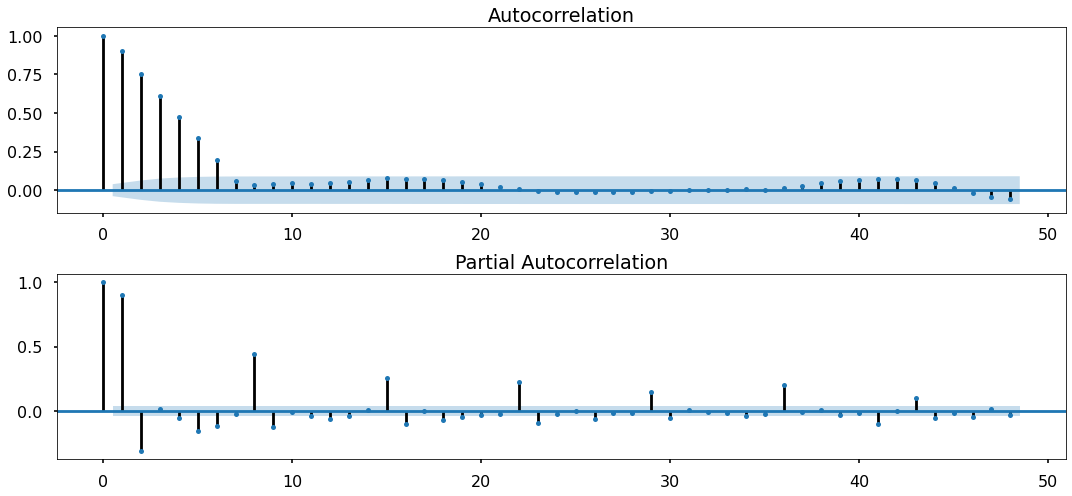

In [175]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Price_box_cox_s_diff[7:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Price_box_cox_s_diff[7:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [190]:
print("Dickey–Fuller test: p = " , sm.tsa.stattools.adfuller(df.Price_box_cox_s_diff[7:])[1])

Dickey–Fuller test: p =  1.1221233286778797e-14


## Mevsimsel Farkın ilk Farkı

In [177]:
df['Price_box_cox_s_diff_2'] =df.Price_box_cox_s_diff - df.Price_box_cox_s_diff.shift(1)
df.head(10)

,Price,Price_box_cox,Price_box_cox_s_diff,Price_box_cox_s_diff_2
Date,,,,
2015-01-01,317.45,7.144990,NaN,NaN
2015-01-02,314.75,7.132041,NaN,NaN
2015-01-03,300.35,7.061186,NaN,NaN
2015-01-04,272.90,6.916921,NaN,NaN
2015-01-05,270.60,6.904229,NaN,NaN
2015-01-06,278.30,6.946333,NaN,NaN
2015-01-07,288.40,6.999952,NaN,NaN
2015-01-08,285.85,6.986581,-0.158409,NaN
2015-01-09,283.95,6.976546,-0.155494,0.002915


In [200]:
print("Dickey–Fuller test: p = " , sm.tsa.stattools.adfuller(df.Price_box_cox_s_diff_2[8:])[1])

Dickey–Fuller test: p =  1.5927614712358739e-28


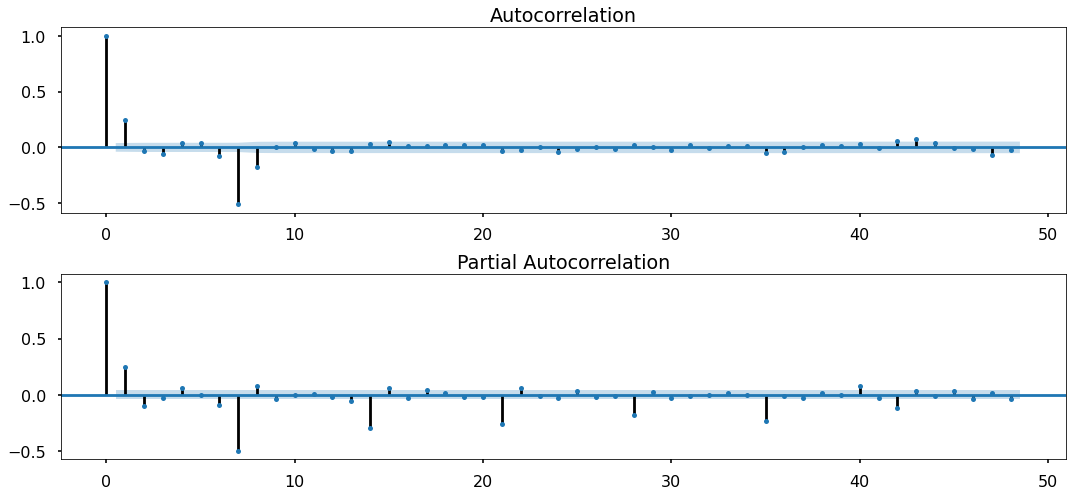

In [179]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Price_box_cox_s_diff_2[8:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Price_box_cox_s_diff_2[8:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

<Figure size 1080x504 with 0 Axes>

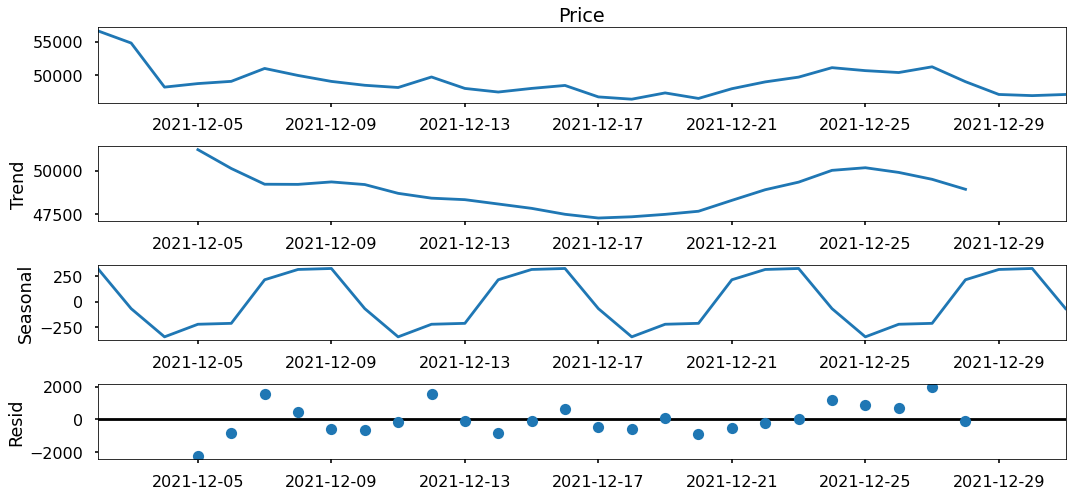

In [180]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df.Price[8:][-30:]).plot()
plt.show()

**ACF grafiğini tekrar incellediğimizde seri’nin durağan hale geldiğini görüyoruz. Eğer iki grafikte de anlamlı korelasyonlar bulunmasaydı bu kez serinin tamamen rastgele davrandığı ve değerlerin önceki değerlere bağlı olmadığı yorumunu yapacaktık.**

## Model Seçimi

In [182]:
Qa = range(0, 2)
Qs = range(0, 3)
Pa = range(0, 3)
Ps = range(0, 3)
Da=1
Ds=1
parameters = product(Pa, Qa, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df.Price_box_cox, order=(param[0], Da, param[1]), 
              seasonal_order=(param[2], Ds, param[3], 7)).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param

In [183]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     Price_box_cox   No. Observations:                 2557
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                3588.272
Date:                           Wed, 05 Jan 2022   AIC                          -7170.543
Time:                                   07:19:13   BIC                          -7153.013
Sample:                               01-01-2015   HQIC                         -7164.185
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2768      0.010     26.417      0.000       0.256       0.297
ma.S.L7       -1.0000      0.404     -2.478

## Tahmin

In [137]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [138]:
end_=len(df)
end_

2557

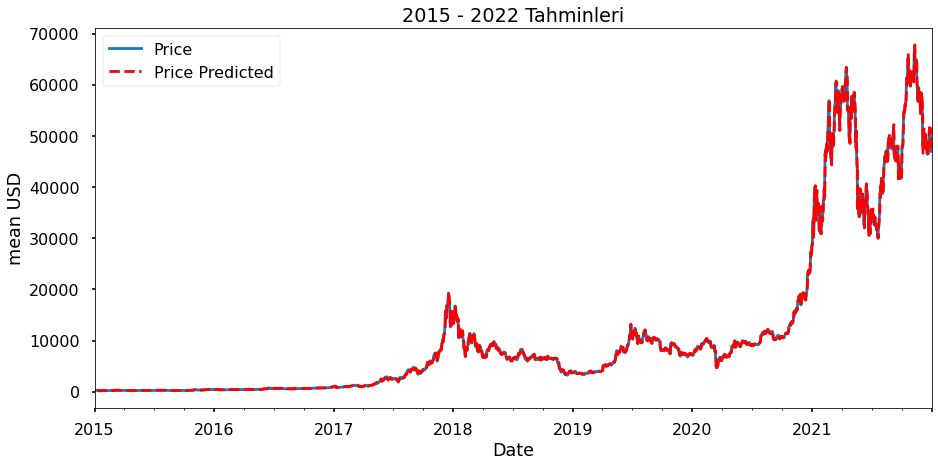

,Price,forecast
Date,,
2015-01-01,317.45,NaN
2015-01-02,314.75,NaN
2015-01-03,300.35,NaN
2015-01-04,272.90,NaN
2015-01-05,270.60,NaN
...,...,...
2021-12-27,51237.65,50491.935923
2021-12-28,49024.75,51529.425397
2021-12-29,47124.75,48423.757490


In [231]:
df2 = df[['Price']]
df2['forecast'] = invboxcox(best_model.predict(start=8, end=end_), lmbda)
plt.figure(figsize=(15,7))
df2.Price.plot()
df2.forecast.plot(color='r', ls='--', label='Price Predicted')
plt.legend()
plt.title('2015 - 2022 Tahminleri')
plt.ylabel('mean USD')
plt.show()
df2

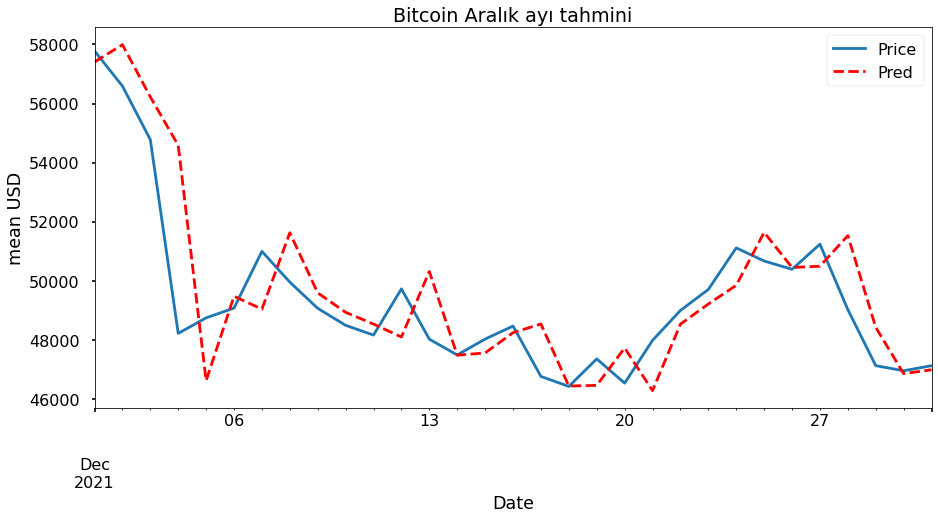

In [147]:
df3= df[['Price']][-31:]
df3['forecast'] = invboxcox(best_model.predict(start=end_-31, end=end_), lmbda)
plt.figure(figsize=(15,7))
df3.Price.plot()
df3.forecast.plot(color='r', ls='--', label='Pred')
plt.legend()
plt.title('Bitcoin Aralık ayı tahmini')
plt.ylabel('mean USD')
plt.show()

In [141]:
df3.head(30)

,Price,forecast
Date,,
2021-12-01,57780.40,57405.918664
2021-12-02,56592.70,57992.777653
2021-12-03,54776.25,56226.065490
2021-12-04,48217.50,54583.132767
2021-12-05,48743.55,46615.936016
2021-12-06,49075.60,49475.081404
2021-12-07,50994.75,49038.194485
2021-12-08,49952.70,51624.439178
2021-12-09,49066.05,49589.468325


In [142]:
y_train=df3.Price
y_train_pred=df3.forecast
evals_()

y_train / y_train_pred 
------------------------------------
R2_score 	: 0.619505942498935
MAE 		: 1139.348421047522
MSE 		: 2730272.4118307177
RMSE 		: 1652.3535976995715


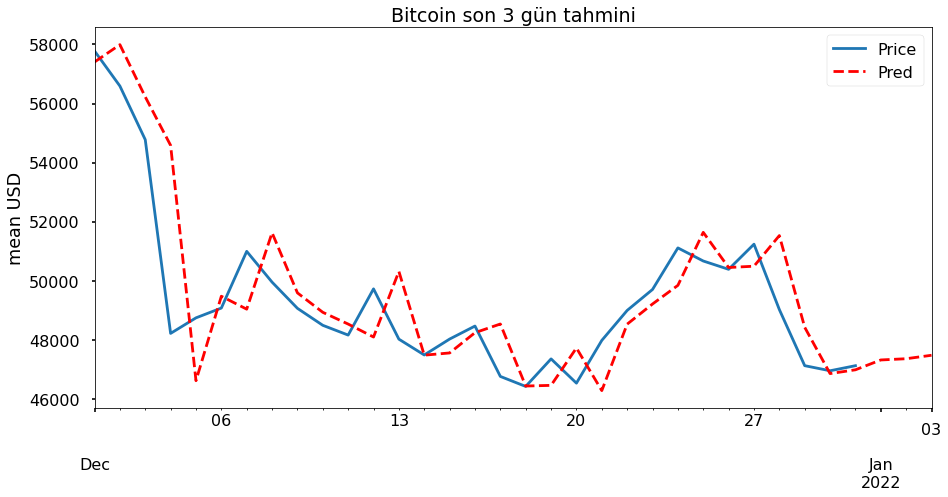

In [226]:
df4 = df[['Price']][-31:]
date_list =[datetime(2022, 1,1), datetime(2022,1,2), datetime(2022,1,3)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df4 = pd.concat([df3, future])
df4['forecast'] = invboxcox(best_model.predict(start=end_-31, end=end_+3), lmbda)
plt.figure(figsize=(15,7))
df4.Price.plot()
df4.forecast.plot(color='r', ls='--', label='Pred')
plt.legend()
plt.title('Bitcoin son 3 gün tahmini')
plt.ylabel('mean USD')
plt.show()

In [160]:
df4[["Price","forecast"]].tail(5)

,Price,forecast
2021-12-30,46952.20,46856.863661
2021-12-31,47123.75,46984.671537
2022-01-01,NaN,47317.780643
2022-01-02,NaN,47359.862215
2022-01-03,NaN,47476.926577


01.01.2022	47.755,0
02.01.2022	47.314,0
03.01.2022	46.445,0